<cite>Darryl Oatridge, August 2022<cite>

# Building a Synthetic Component
Synthetic Builder is another example of a Project Hadron capability, having seen selection and feature engineering in our previous examples. Synthetic Builder uses a combination of rules-based actions, defined by subject matter experts along with machine learning libraries and techniques, to define a set of statistically and distributed representative datasets. 

In this example we demonstrate the basics of a common use case of customer account details showing quick wins through the tooling when building this type of synthetic dataset.

Project Hadron Canonicalizes data following the canonical model pattern so that every component speaks the same data language. In this case and with this package all components use Pandas DataFrame format. This is common format used by data scientists and statisticians to manipulate and visualise large datasets. 

Before we do that, and as shown in the previous section, we now use the environment variables to define the location of the Domain Contract and datastore.

In [19]:
import os 

In [20]:
os.environ['HADRON_PM_PATH'] = '0_hello_meta/synthetic/contracts'
os.environ['HADRON_DEFAULT_PATH'] = '0_hello_meta/synthetic/data'

## Setting Up
We initially load Project Hadron's Synthetic Builder instance that provides us access to its capabilities. It is worth noting, synthetic Builder shares some of its actions (Intent) with the feature engineering capability adding additional actions (Intent) to generate the initial data or feature distribution.

Notice we are creating a new component and as such must set up the output of the component. With synthetic build, though it can be defined, there is no concept of a synthetic source as synthetic data in its on right creates that source dataset. 

In [21]:
from ds_discovery import SyntheticBuilder

In [22]:
# get the instance
builder = SyntheticBuilder.from_env('hello_builder', has_contract=False)

In [23]:
builder.set_persist()

## Building a Distribution
This new component works in exactly the same way as the other components demonstrated earlier, whereby we create the instance pertinent to our intentions and where to persist the results. Then we add the component actions (intent), which in this case is to generste the features we have built and make them appropriate for a machine learning model or for other uses. 

As seen before in order to get a list of a component's actions (intent), in this case synthetic builder, you can use the Python method `__dir__()`. Remember this method call can be used in any component.

As we do not have a source we first need to define our DataFrame that the data will fit into and for convenience we create a variable for the sample size that can be applied to all required build methods.

In [24]:
import pandas as pd

sample_size = 1000
df = pd.DataFrame(index=range(sample_size))

### Building a Member
We initially need to create the distribution data using the `get_` methods. In this case we are using `get-numbers` to retrieve a random set of values and using the `at_most` parameter to specify those values to be unique.  

Next use `get_catagory` to define `language` using the `relative_freq` parameter to specify the distribution of these catagories. 

Finally use `get_datetime` to get a date of birth of the member based on current time. We achieve this by using seconds from now, be they posative or negative, to calculate a datetime. Dates now stay up to date each run, though real date margins can be used.

In [25]:
df['member_id'] = builder.tools.get_number(from_value=100000, to_value=999999, at_most=1, size=sample_size, column_name='member_id')

In [26]:
df['language'] = builder.tools.get_category(selection=['ENGL', 'SPAN', 'CHIN', 'RUSS', 'OTHERS'], relative_freq=[92,6,1,1,.4], size=sample_size, column_name='language')

In [27]:
df['mbr_dob'] = builder.tools.get_datetime(start=-29500, until=-730, relative_freq=[0.001,0.1,1,3,5,3,2,2,4,3,3,2,1], size=sample_size, column_name='mbr_dob')

<AxesSubplot:xlabel='mbr_dob', ylabel='Count'>

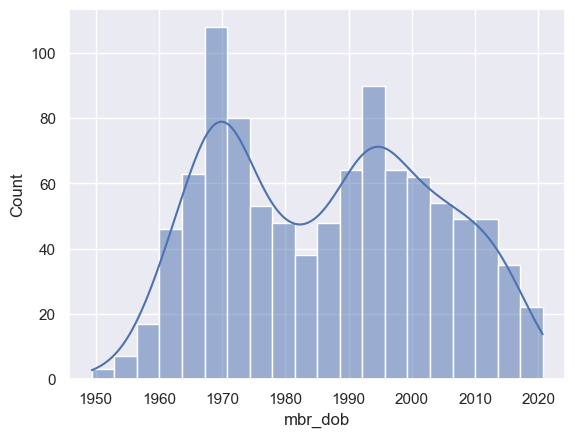

In [28]:
import seaborn as sns

sns.set()
sns.histplot(df['mbr_dob'], bins=20, kde=True)

### Adding Demographics

When creating personas there are a number of sample data methods. Use persona to retrieve names that match gender and email with the ability to bias the gender gap. Use zipcodes to retrieve a rich sample of location data that is correctly biased towards population density. With both these sample methods there are a couple of parameters to filter on the data you want to retrieve, be that columns or rows.

In [29]:
# persona
df = builder.tools.model_sample_map(canonical=df, sample_map='us_persona', female_bias=0.55, column_name='persona', )

In [30]:
# zipcode
df = builder.tools.model_sample_map(canonical=df, sample_map='us_zipcode', column_name='zipcodes')

### Adding Preferences
Add preferances for now and to use later as we improve the logic. Remember synthetic building is an iterative process that builds up as one's knowledge improves.

In [31]:
# has phone number
df['prf_has_phone'] = builder.tools.get_category(selection=[1, 0], relative_freq=[15,1], size=sample_size, column_name='prf_has_phone')

In [32]:
# communication channel preference
channels = ["MyPortal", "Phone", "Email", "SMS", "SocialMedia"]
df['prf_channel_pref'] = builder.tools.get_category(selection=channels, relative_freq=[4,1,3,2,2], size=sample_size, column_name='prf_channel_pref')

### Adding Logic
Using the preferences we can now add more distributive features to our feature set using logical gates. In the first instance we are aligning phone number. We then align our mobile apps to specific preferences

In [33]:
# ensure if the member has no phone number the channel preference is not SMS or Phone
selection = [builder.tools.select2dict(column='prf_has_phone', condition='@==0')]

action = builder.tools.action2dict(method='get_category', selection=["MyPortal", "SocialMedia", "Email"], relative_freq=[2,1,2])
default = builder.tools.action2dict(method='@header', header='prf_channel_pref')

df['prf_channel_pref'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_channel_pref', intent_order=-1)

In [34]:
# ensure those with mobile apps can elect to opt out of sales and marketing
A = builder.tools.select2dict(column='prf_channel_pref', condition="@=='SocialMedia'")
B = builder.tools.select2dict(column='prf_channel_pref', condition="@=='MyPortal'", logic='AND')
selection = [A, B]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[1,50])
default = builder.tools.action2dict(method='@constant', value=0)

df['prf_service_only'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_service_only')

## Run Component Pipeline
To run a component we use the common method `run_component_pipeline` which loads the source data, executes the component task then persists the results. This is the only method you can use to run the tasks of a component and produce its results and should be a familiarized method.

We can now run the `run_component_pipeline` and use the canonical report to observe the outcome.  From it we can see the columns we have created, and have been created for us, for the synthetic build.

In [35]:
builder.run_component_pipeline()
builder.canonical_report(builder.load_persist_canonical(), stylise=False)

,Attributes (17),dType,%_Null,%_Dom,Count,Unique,Observations
0,city,object,0.000,0.006,1000,898,Sample: Houston | Washington | New York | Queens | Columbus
1,county,object,0.000,0.013,1000,556,Sample: Montgomery | Madison | Washington | Los Angeles | Grant
2,county_fips,int64,0.000,0.010,1000,707,max=72113 | min=1025 | mean=30164.25 | dominant=6037
3,email,object,0.000,0.001,1000,1000,Sample: liani.burghardt@gmx.net | sally.rilee@gmx.com | yina.felkel@mail.com | maisen.webberley@bell...
4,family_name,object,0.000,0.002,1000,993,Sample: Dumpit | Offringa | Massad | Moede | Davidheiser
5,first_name,object,0.000,0.002,1000,999,Sample: Harlyn | Liani | Sally | Yina | Maisen
6,gender,object,0.000,0.551,1000,2,Sample: F | M
7,language,object,0.000,0.916,1000,5,Sample: ENGL | SPAN | CHIN | RUSS | OTHERS
8,mbr_dob,datetime64[ns],0.000,0.001,1000,1000,max=2020-10-13 13:32:45.582532 | min=1949-02-08 14:18:29.996446 | yr mean= 1985
9,member_id,int64,0.000,0.001,1000,1000,"max=999549 | min=100449 | mean=555430.05 | dominant=[100449, 101799]"
